# Migration Part 2
## Subtitle: What is a `QuantumComputer`

Pyquil is for constructing and running quantum programs on real quantum computers. With the release of Pyquil 2, we have changed parts of the API to better reflect that focus. Instead of swapping between a `QVMConnection` and a `QPUConnection`, you will primarily deal with a `QuantumComputer` with consistent API and behavior regardless of

 - QVM / QPU
 - Presence of noise model
 - Device topology
 
## Running a program
Let's show how you can run a simple program on a `QuantumComputer` first we start with the relevant Pyquil imports.

In [ ]:
from pyquil import Program
from pyquil.gates import *

We'll write a function that takes a list of qubits and returns a pyquil `Program` that constructs an entangled "GHZ" state. This is a generalization of the two-qubit Bell state.

In [ ]:
def ghz_state(qubits):
    """Create a GHZ state on the given list of qubits by applying a Hadamard gate to the
    first qubit followed by a chain of CNOTs
    """
    program = Program()
    program += H(qubits[0])
    for q1, q2 in zip(qubits, qubits[1:]):
        program += CNOT(q1, q2)
    return program

For example, creating a GHZ state on qubits 1, 2, and 3 would look like:

In [ ]:
program = ghz_state(qubits=[0, 1, 2])
print(program)

## Debugging with `WavefunctionSimulator`
We can check that this program gives us the desired wavefunction by using `WavefunctionSimulator.wavefunction()`

In [ ]:
from pyquil.api import WavefunctionSimulator
wfn = WavefunctionSimulator().wavefunction(program)
print(wfn)

We can't get the wavefunction from a real quantum computer though, so instead we'll sample bitstrings. We expect to always measure the bitstring 000 or the bitstring 111 based on the definition of a GHZ state and confirmed by our wavefunction simulation

## Pre-configured `QuantumComputer`s

We'll construct a `QuantumComputer` via the helper method `get_qc`. You may be tempted to use the `QuantumComputer` constructor directly. Please refer to the [advanced documentation]() to see how to do that. Our program uses 3 qubits, so we'll ask for a 3-qubit QVM

In [ ]:
from pyquil import get_qc
qc = get_qc('3q-qvm')
qc

We can do a quick check to make sure it has 3 qubits

In [ ]:
qc.qubits()

## Sampling with `run_and_measure`

`QuantumComputer.run_and_measure` will run a given program (that does not have explicit `MEASURE` instructions) and then measure *all qubits present in the quantum computer*.

In [ ]:
bitstrings = qc.run_and_measure(program, trials=10)
bitstrings

Let's programatically verify that we always measure 000 or 111 by "summing" each bitstring and checking if it's eather 0 (for 000) or 3 (for 111)

In [ ]:
import numpy as np
bitstring_array = np.vstack(bitstrings[q] for q in qc.qubits()).T
sums = np.sum(bitstring_array, axis=1)
sums

In [ ]:
sample_is_ghz = np.logical_or(sums == 0, sums == 3)
sample_is_ghz

In [ ]:
np.all(sample_is_ghz)

## Change alert: `run_and_measure` will return a dictionary of 1d bitstrings.

*Not* a 2d array. To demonstrate why, consider a lattice whose qubits are not contiguously indexed from 0.

In [ ]:
# TODO: we need a lattice that is not zero-indexed
# qc = get_qc('Aspen-0-3Q-B')
# qc.run_and_measure(ghz_state(qubits=[1,2,3]))

## Change alert: All qubits are measured

 Pyquil 1.x's `run_and_measure` would only measure qubits used in the given program. Now all qubits (per `qc.qubits()`) are measured. This is easier to reason about and reflects the reality of running on a QPU. When accounting for noise or when running QCVV tasks, you may be interested in the measurement results of qubits that weren't even used in your program!

In [ ]:
qc = get_qc('4q-qvm')
bitstrings = qc.run_and_measure(Program(X(0), X(1), X(2)), trials=10)
bitstrings

You can drop qubits you're not interested in by indexing into the returned dictionary

In [ ]:
# Stacking everything
np.vstack(bitstrings[q] for q in qc.qubits()).T

In [ ]:
# Stacking what you want (contrast with above)
qubits = [0, 1, 2]
np.vstack(bitstrings[q] for q in qubits).T

## Change alert: `run_and_measure` works with noise models now.

In Pyquil 1.x, `run_and_measure` would not work with noise models. Now noise models are supported. Pre-configured noise models can be used via `get_qc('xxxx-noisy-qvm')`.

As a consequence, `run_and_measure` for large numbers of trials will be slower in Pyquil 2.

In [ ]:
qc = get_qc('3q-noisy-qvm')
bitstrings = qc.run_and_measure(program, trials=10)
bitstrings

In [ ]:
bitstring_array = np.vstack(bitstrings[q] for q in qc.qubits()).T
sums = np.sum(bitstring_array, axis=1)
sums

In [ ]:
# Noise means now we measure things other than 000 or 111
np.all(np.logical_or(sums == 0, sums == 3))

## `get_qc` possibilities
Please check the [Documentation]() for more. Something about how you can have qvm versions of deployed lattices. Depends on the web endpoint being exposed

## `QuantumComputer`s have a topology

An important restriction when running on a real quantum computer is the mapping of qubits to the supported two-qubit gates. The QVM is designed to provide increasing levels of "realism" to guarantee that if your program executes successfully on `get_qc("Aspen-xxx-noisy-qvm")` then it will execute successfully on `get_qc("Aspen-xxx")`*

\* guarantee not currently guaranteed. This is a work in progress.

## Inspecting the topology
You can access a topology by `qc.qubit_topology()`, which will return a NetworkX representation of qubit connectivity. You can access the full set of supported instructions by `qc.get_isa()`. For example, we include a generic QVM named `"9q-square-qvm"` that has a square topology.

In [ ]:
qc = get_qc('9q-square-qvm')
%matplotlib inline
import networkx as nx
nx.draw(qc.qubit_topology())
from matplotlib import pyplot as plt
_ = plt.title('9q-square-qvm', fontsize=18)

## What If I don't want a topology?

`WavefunctionSimulator` still has no notion of qubit connectivity, so feel free to use that for simulating quantum algorithms that you aren't concerned about running on an actual QPU. 

Above we used `get_qc("3q-qvm")`, `"4q-qvm"`, and indeed you can do any `"{n}q-qvm"` (subject to computational resource constraints). These QVM's are constructed with a topology! It just happens to be fully connected

In [ ]:
nx.draw(get_qc('5q-qvm').qubit_topology())
_ = plt.title('5q-qvm is fully connected', fontsize=16)

## Heirarchy of realism

 - `WavefunctionSimulator` to debug algorithm
 - `get_qc("5q-qvm")` to debug sampling
 - `get_qc("9q-square-qvm")` to debug mapping to a lattice
 - `get_qc("9q-square-noisy-qvm"`) to debug generic noise characteristics
 - `get_qc("Aspen-0-16Q-A-qvm")` to debug mapping to a real lattice
 - `get_qc("Aspen-0-16Q-A-noisy-qvm")` to debug noise characteristics of a real device
 - `get_qc("Aspen-0-16Q-A")` to run on a real device

## "What is a `QuantumComputer`?" Advanced Edition

A `QuantumComputer` is a wrapper around three constituent parts, each of which has a programatic interface that must be respected by all classes that implement the interface. By having clear interfaces we can write backend-agnostic methods on `QuantumComputer` and mix-and-match backing objects.

The following diagram shows the three objects that must be provided when constructing a `QuantumComputer` "by hand". The abstract classes are backed in grey with example implementing classes listed below. Please consult the [api reference]() for details on each interface.

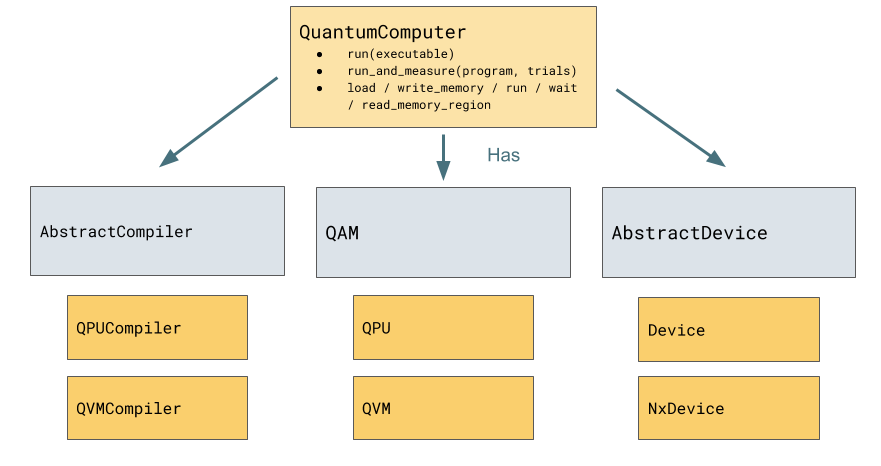

As an example, let's construct a 5-qubit QVM with one central node and only even numbered qubits.

In [ ]:
topology = nx.from_edgelist([
    (10, 2),
    (10, 4),
    (10, 6),
    (10, 8),
])
from pyquil.device import NxDevice
device = NxDevice(topology)

from pyquil.api._qac import AbstractCompiler
class MyLazyCompiler(AbstractCompiler):
    def quil_to_native_quil(self, program):
        return program
    
    def native_quil_to_executable(self, nq_program):
        return nq_program
    
    
from pyquil.api import QuantumComputer, QVM, ForestConnection
my_qc = QuantumComputer(
    name='my-qvm',
    qam=QVM(connection=ForestConnection()),
    device=device,
    compiler=MyLazyCompiler(),
)

nx.draw(my_qc.qubit_topology())

In [ ]:
my_qc.run_and_measure(Program(X(10)), trials=5)